In [1]:
import tensorflow as tf
#import imageio
import numpy as np
import edward as ed
#import pystan
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
from datetime import datetime
import pickle
import json
import seaborn as sns
from edward.models import Categorical, Dirichlet, InverseGamma, Normal, MultivariateNormalDiag, Mixture, Empirical, ParamMixture
%matplotlib inline

In [2]:
img_no = 2092

In [3]:
#train_path = "/Users/leah/Columbia/courses/ml_prob_programming/ENV/BSR/BSDS500/data/images/train"
train_path = "../data/BSR/BSDS500/data/images/train/{}.jpg".format(img_no)

In [4]:
img = plt.imread(train_path)

In [5]:
img.shape

(321, 481, 3)

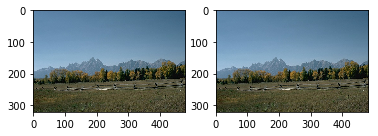

In [6]:
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(img)
fig.add_subplot(1,2,2)
plt.imshow(img)
plt.show()

In [7]:
train_img = img.reshape(-1, 3).astype(int)

In [8]:
train_img.shape

(154401, 3)

# MCMC

In [9]:
# Hyperparameters
# 11/5/2018此处已经改动
N = train_img.shape[0] 
K = 20
D = train_img.shape[1]
ed.set_seed(1234)

In [10]:
train_img.shape

(154401, 3)

In [11]:
with tf.name_scope("model"):
    pi = Dirichlet(concentration=tf.constant([1.0] * K, name="pi/weights"), name= "pi")
    mu = Normal(loc= tf.zeros(D, name="centroids/loc"), 
                scale= tf.ones(D, name="centroids/scale"), 
                sample_shape=K, name= "centroids")
    sigma = InverseGamma(concentration=tf.ones(D, name="variability/concentration"), 
                         rate=tf.ones(D, name="variability/rate"), sample_shape=K, name= "variability")

    x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigma)},
                     MultivariateNormalDiag,
                     sample_shape=N, name= "mixture")
    z = x.cat

In [12]:
T = 1000  # number of MCMC samples
with tf.name_scope("posterior"):
    qpi = Empirical(tf.get_variable(
        "qpi/params", [T, K],
        initializer=tf.constant_initializer(1.0/K)))
    qmu = Empirical(tf.get_variable(
        "qmu/params", [T, K, D],
        initializer=tf.zeros_initializer()))
    qsigma = Empirical(tf.get_variable(
        "qsigma/params", [T, K, D],
        initializer=tf.ones_initializer()))
    qz = Empirical(tf.get_variable(
        "qz/params", [T, N],
        initializer=tf.zeros_initializer(),
        dtype=tf.int32))

In [13]:
# declare time
Gibbs_inference_startTime = time.time()
current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [14]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigma: qsigma, z: qz},
                     data={x: train_img})

/Users/zhonglingjiang/anaconda3/envs/mlprobprog/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/Users/zhonglingjiang/anaconda3/envs/mlprobprog/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


In [15]:
inference.initialize(n_print=200, logdir='log/IMG={}_K={}_T={}'.format(img_no, K, T))
sess = ed.get_session()
tf.global_variables_initializer().run()
t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

In [16]:
learning_curve = []
for _ in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    t = info_dict['t']
    if t % inference.n_print == 0:
        print("\nInferred cluster means:")
        last_mu = sess.run(running_cluster_means, {t_ph: t - 1})
inference.finalize()

  50/1000 [  5%] █                              ETA: 4360s | Acceptance Rate: 1.000
Inferred cluster means:
[[9.90964737e+01 1.26222099e+02 1.42810806e+02]
 [7.14416206e-01 3.98774058e-01 3.08889568e-01]
 [5.63791871e-01 1.54423130e+00 1.05563986e+00]
 [1.93877593e-01 1.11125708e+00 3.89923006e-01]
 [1.65815681e-01 7.01948822e-01 5.14723718e-01]
 [4.14501399e-01 2.02126408e+00 3.16739511e+00]
 [1.18177252e+01 1.53492155e+01 7.06851196e+00]
 [3.98634958e+00 1.09850693e+00 8.55822265e-02]
 [5.02831221e-01 9.41445649e-01 7.90029466e-02]
 [4.60697441e+01 4.78184586e+01 2.96828709e+01]
 [1.52612019e+00 7.38449478e+00 4.76489353e+00]
 [2.98508495e-01 6.02287650e-01 6.27537668e-01]
 [1.79232872e+00 8.77706051e+00 6.20172918e-01]
 [1.58448130e-01 5.61817467e-01 1.14048250e-01]
 [1.73145473e-01 9.90765631e-01 1.54033020e-01]
 [3.38650346e+00 4.70411348e+00 2.48005614e-01]
 [3.63488555e-01 2.27357364e+00 5.00145219e-02]
 [3.67326379e-01 2.57102442e+00 1.17354609e-01]
 [2.39777163e-01 5.69918990e

 450/1000 [ 45%] █████████████                  ETA: 2440s | Acceptance Rate: 1.000
Inferred cluster means:
[[1.03925835e+02 1.37781784e+02 1.64668747e+02]
 [2.26089284e-01 2.06178442e-01 3.62249792e-01]
 [9.76254940e-01 2.75386286e+00 1.41628969e+00]
 [2.86768764e-01 2.23623008e-01 3.31743509e-01]
 [1.17233358e-01 8.39967847e-01 2.57423472e+00]
 [7.63794804e+00 1.41126976e+01 8.15718079e+00]
 [6.96843491e+01 6.85185776e+01 4.43451881e+01]
 [1.44083273e+00 3.38710874e-01 3.63928825e-01]
 [2.62432188e-01 4.18034852e-01 4.46947694e-01]
 [8.91248932e+01 8.60638046e+01 6.04948006e+01]
 [5.27397270e+01 5.39294968e+01 3.20464897e+01]
 [3.51655543e-01 3.48372459e-01 3.80727202e-01]
 [3.50045128e+01 3.87114830e+01 2.04644928e+01]
 [1.28515169e-01 3.25926232e+00 1.46087611e+00]
 [3.33062243e+00 6.18869829e+00 3.78878474e+00]
 [6.82422924e+00 1.00334444e+01 5.48201241e-02]
 [1.27140135e-01 4.22298288e+00 5.01000555e-03]
 [2.55866587e-01 6.58400178e-01 3.32510293e-01]
 [1.82732403e-01 1.17168948e

 850/1000 [ 85%] █████████████████████████      ETA: 667s | Acceptance Rate: 1.000
Inferred cluster means:
[[1.0417573e+02 1.3854900e+02 1.6621729e+02]
 [2.3442608e-01 1.8452610e-01 4.1146350e-01]
 [3.4182224e+00 6.3409681e+00 4.0485010e+00]
 [2.9819146e-01 1.8266936e-01 3.0006319e-01]
 [1.4337935e-01 6.2988698e-01 1.9100760e+00]
 [1.4790517e+01 2.1891611e+01 1.1587070e+01]
 [7.7104141e+01 7.5213249e+01 5.0154469e+01]
 [1.9256864e+00 2.6242504e+00 1.1930627e+00]
 [2.3761517e-01 3.2840374e-01 3.9445639e-01]
 [9.3676414e+01 9.0247665e+01 6.4092072e+01]
 [6.2502998e+01 6.2464977e+01 3.8362934e+01]
 [2.7778912e-01 2.9625458e-01 3.0892947e-01]
 [4.6885311e+01 4.9027149e+01 2.7384897e+01]
 [7.6373719e-02 5.1395597e+00 2.5593927e+00]
 [6.5139990e+00 1.1014147e+01 6.8852625e+00]
 [7.1964450e+00 1.0588384e+01 2.9039666e-02]
 [6.7243509e-02 4.3869042e+00 2.5115120e-03]
 [3.2535324e-01 5.0473404e-01 3.8702130e-01]
 [3.2130265e-01 3.1645584e-01 3.7717736e-01]
 [3.0950678e+01 3.5505272e+01 1.789514

In [17]:
Gibbs_inference_elapsedTime = time.time() - Gibbs_inference_startTime

In [36]:
posterior_mu = qmu.params.eval().mean(axis=0)

In [20]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).]
M = 300 
mu_sample = qmu.sample(M)
sigmasq_sample = qsigma.sample(M)
pi_sample = qpi.sample(M)
x_post = Normal(loc=tf.ones([N, 1, 1, 1]) * mu_sample,
                scale=tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample))
x_broadcasted = tf.tile(tf.reshape(train_img, [N, 1, 1, D]), [1, M, K, 1])
x_broadcasted = tf.cast(x_broadcasted, dtype= tf.float32)

In [21]:
# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3) 
log_liks = tf.reduce_mean(log_liks, 1)

In [22]:
clusters = tf.argmax(log_liks, 1).eval()

In [23]:
result_img_dirs = '../tmp/img_result/{}'.format(current_time)
os.makedirs(result_img_dirs)

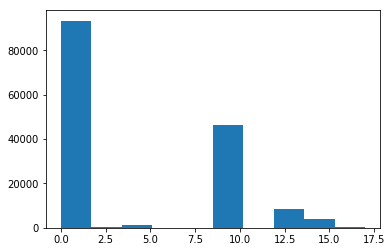

In [24]:
plt.hist(clusters)
plt.savefig('../tmp/img_result/{}/cluster_dist_img={}_K={}_T={}_Time={}.png'.format(current_time,img_no, K, T, current_time))

In [25]:
#new_img = tf.gather(running_cluster_means, tf.argmax(log_liks, 1))

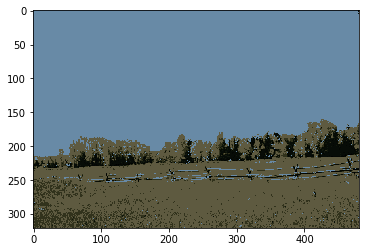

In [40]:
nrows, ncols = img.shape[0], img.shape[1]
segmented_img = np.zeros((nrows, ncols, D),dtype='int')
cluster_reshape = clusters.reshape(nrows, ncols)
result_cluster_assign_dirs = '../tmp/log/cluster_assign_matrix'
os.makedirs(result_cluster_assign_dirs)
np.save(result_cluster_assign_dirs + "/cluster_assign={}_K={}_T={}_Time={}.npy".format(img_no, K, T, current_time), cluster_reshape)
for i in range(nrows):
    for j in range(ncols):
        cluster_number = cluster_reshape[i, j]
        segmented_img[i, j] = posterior_mu[cluster_number].astype(int)
fig = plt.figure()
plt.imshow(segmented_img)
plt.savefig('../tmp/img_result/{}/fitted_img={}_K={}_T={}_Time={}.png'.format(current_time,img_no, K, T, current_time))

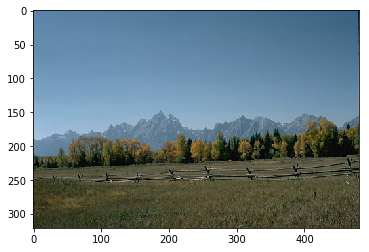

In [41]:
plt.imshow(img)
plt.savefig('../tmp/img_result/{}/original_img={}_K={}_T={}_Time={}.png'.format(current_time, img_no, K, T, current_time))

## Criticism

### Posterior Predictive

1. Sample from posterior q$(\pi)$ (M = 100 samples). Exponentiate `log_liks` to get $p_k = exp(pi_i)$
2. Calculate mixture likelihood for each sample of pi. $p(x | \pi_i) = \sum_{k = 1}^K \pi_{ik} * p_k$ where k is a class.
3. Average over all $p(x | \pi_i)$ for i = 1 to M.
4. Take product of all likelihood over $x$ (value too small) OR sum of log likelihood over $x$

In [42]:
# Step 1: 
 # (100 * K)
#p_k = tf.exp(log_liks) # (N * K)
#weighted_liks = tf.matmul(pi_sample, tf.transpose(p_k))  
#log_expected_liks = tf.log(tf.reduce_mean(weighted_liks, 0))
#total_log_expected_liks = tf.reduce_sum(log_expected_liks, 0)

In [43]:
# modify defintion # wrong
#log_liks_over_all_points = tf.reduce_sum(log_liks, 0)
# no log sum trick
#max_x_i = 
#liks_over_all_points = tf.expand_dims(tf.exp(log_liks_over_all_points),0)
#total_log_expected_liks_2 = tf.reduce_mean(tf.log(tf.matmul(liks_over_all_points, tf.transpose(pi_sample))))

In [44]:
# correction part
log_liks_3 = x_post.log_prob(x_broadcasted)
log_liks_3 = tf.reduce_sum(log_liks_3, 3) #[N, M, K]
pi_samples_tiled_3 = tf.tile(tf.expand_dims(tf.log(pi_sample), 0), [N, 1,1]) # [500, 100, 7], [N, M, K]
sum_log_pi_normal_3 = tf.add(pi_samples_tiled_3,log_liks_3) # [500, 100, 7]
x_max_3 = tf.reduce_max(sum_log_pi_normal_3, axis=2) # [500, 100]
edited_log_sum_3 = tf.add(x_max_3, tf.log(tf.reduce_sum(tf.exp(sum_log_pi_normal_3 - tf.expand_dims(x_max_3, 2)), axis=2))) #[500, 100]
averaged_total_log_liks_over_pi_samples_3 = tf.reduce_mean(tf.reduce_sum(edited_log_sum_3, 0), 0)
averaged_expected_log_liks_over_pi_samples_3 = tf.reduce_mean(tf.reduce_mean(edited_log_sum_3, 0), 0)
averaged_log_liks_pointwise = tf.reduce_mean(edited_log_sum_3, 1)

In [45]:
# using log sum trick
#log_pi_sample = tf.log(pi_sample)    #错误: 在上一步时log_liks 不应该合并先100个(mu, sigma)sample. 而是应该把pi 与这些(mu,sigma)并列。

#pi_sample_expand = tf.expand_dims(tf.log(pi_sample), 1) #[100, 1, 7]
#sum_log_pi_normal = tf.add(pi_sample_expand,log_liks) # [100, N, 7]
#x_max = tf.reduce_max(sum_log_pi_normal, axis=2) #[100, N]
#edited_log_sum = tf.add(x_max, tf.log(tf.reduce_sum(tf.exp(sum_log_pi_normal - tf.expand_dims(x_max, 2)), axis=2))) # [100, N]  # log (sum_i(exp(x_i-x_max)))
#averaged_total_log_liks_over_pi_samples = tf.reduce_mean(tf.reduce_sum(edited_log_sum, 1), 0)

In [46]:
total_total_log_liks_value = sess.run(averaged_total_log_liks_over_pi_samples_3)
expected_log_liks_value = sess.run(averaged_expected_log_liks_over_pi_samples_3)
pointwise_log_liks_value = sess.run(averaged_log_liks_pointwise) 

In [47]:
with open('../tmp/log/log_likelihood.txt', 'a') as fp:
    if os.stat("../tmp/log/log_likelihood.txt").st_size == 0:
        fp.write("img,K,T,log_lik,datetime,runtime\n")
    fp.write("{},{},{},{},{},{}\n".format(img_no, K, T,total_total_log_liks_value, current_time, Gibbs_inference_elapsedTime))
print('The data log likeilhood is: {}'.format(total_total_log_liks_value))
print('The data expected log likelihood is: {}'.format(expected_log_liks_value))

The data log likeilhood is: -2107735.25
The data expected log likelihood is: -13.707832336425781


In [48]:
pointwise_log_liks_value

array([-12.767114, -12.797262, -12.797262, ..., -13.714779, -13.097641,
       -12.519803], dtype=float32)

### Posterior Dispersion Index (PDI) and WAPDI

Reference: http://proceedings.mlr.press/v70/kucukelbir17a/kucukelbir17a.pdf

Citation: Kucukelbir, Alp, Yixin, Wang and Blei, David M. Evaluating Bayesian Models with Posterior Dispersion Indices, In $\textit{Proceedings
of the 34th International Conference on Machine Learning,
volume 70 of Proceedings of Machine Learning Research}$,
pages 1925–1934, International Convention Centre, Sydney,
Australia, 06–11 Aug 2017.

Goal: 

Evalute the quantity $\frac{V_{\theta|x} [p(x_n |\theta)]}{E_{\theta|x} [p(x_n |\theta)]}$ for each point $x_n$

Alternatively, evaluate the quantity $\frac{V_{\theta|x} [logp(x_n |\theta)]}{E_{\theta|x} [logp(x_n |\theta)]}$

Steps:
1. We look at a single data point $x_n$ first.
2. Compute the posterior distribution $p(\theta | x)$
3. Sample ${\theta_1, ..., \theta_m}$ where $\theta_i \sim p(\theta|x)$  (In this problem, we need to sample $\pi$)
4. For each $\theta_i$, calculate the likelihood $lik_{ni} = p(x_n | \theta_i)$. Collect $Lik_n = \{lik_{n1}, ..., lik_{nm}\}$
5. Calculate $Var(Lik_n)$ and $Exp(Lik_n)$
6. Repeat the computation for all data points.

During Implementation, we make use of the `log_liks` in the computation graph before, but instead of reducing both 2nd and 4th dimension, we now only reduce 4th dimension because we want to keep these samples. 

In [51]:
# PDI II
pdi_mean, pdi_variance = tf.nn.moments(tf.exp(edited_log_sum_3), axes=[1])
pdi = tf.divide(pdi_variance, pdi_mean)
pdi_values = sess.run(pdi)

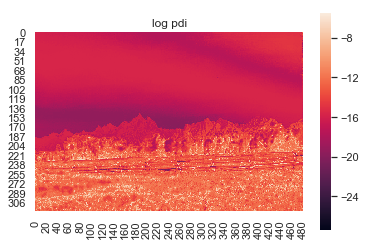

In [52]:
# generate x and y of image
sns.set()
nrows, ncols = img.shape[0], img.shape[1]
log_reshaped_pdi_values = np.log(np.reshape(pdi_values, (nrows, ncols)))
ax = sns.heatmap(log_reshaped_pdi_values)
ax.set_title("log pdi")
plt.imshow(log_reshaped_pdi_values)
plt.savefig('../tmp/img_result/{}/logpdi_img={}_K={}_T={}_Time={}.png'.format(current_time, img_no, K, T, current_time))

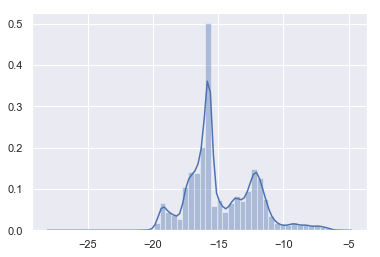

In [53]:
sns.distplot(np.log(pdi_values))

Alternatively, evaluate the quantity $\frac{V_{\theta|x} [logp(x_n |\theta)]}{E_{\theta|x} [logp(x_n |\theta)]}$


In [54]:
# WAPDI 1
#log_p_x_given_theta_3 = tf.reduce_sum(tf.multiply(pi_samples_tiled_3, log_liks_3), axis=2)
#_, wapdi_variance = tf.nn.moments(log_p_x_given_theta_3, axes=[1])
#wapdi_log_mean = tf.log(pdi_mean)
#wapdi = tf.divide(wapdi_variance, wapdi_log_mean)
#wapdi_values = sess.run(wapdi)

In [55]:
# WAPDI 2
_, wapdi_variance = tf.nn.moments(edited_log_sum_3, axes=[1])
wapdi_log_mean = tf.log(pdi_mean)
wapdi = tf.divide(wapdi_variance, wapdi_log_mean)
wapdi_values = sess.run(wapdi)

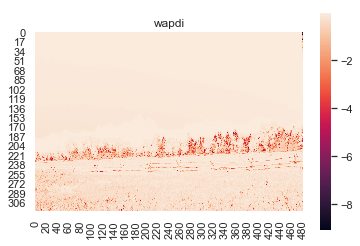

In [56]:
sns.set()
reshaped_wapdi_values = np.reshape(wapdi_values, (nrows, ncols))
ax = sns.heatmap(reshaped_wapdi_values)
ax.set_title("wapdi")
plt.imshow(reshaped_wapdi_values)
plt.savefig('../tmp/img_result/{}/wapdi_img={}_K={}_T={}_Time={}.png'.format(current_time,img_no, K, T, current_time))

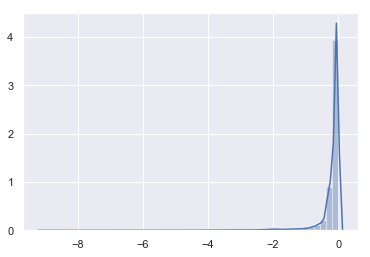

In [57]:
sns.distplot(wapdi_values)

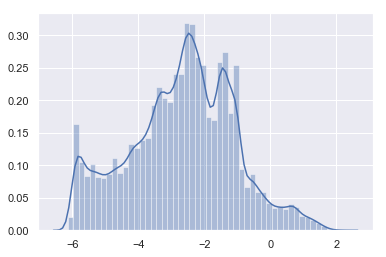

In [58]:
sns.distplot(np.log(-wapdi_values))

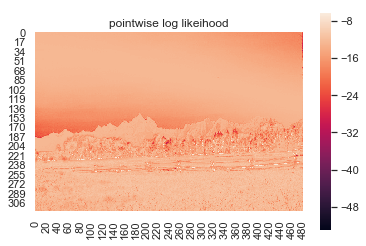

In [59]:
# pointwise_log_likelihood
sns.set()
reshaped_log_likelihood_values = np.reshape(pointwise_log_liks_value, (nrows, ncols))
ax = sns.heatmap(reshaped_log_likelihood_values)
ax.set_title("pointwise log likeihood")
plt.imshow(reshaped_log_likelihood_values)
plt.savefig('../tmp/img_result/{}/logliks_img={}_K={}_T={}_Time={}.png'.format(current_time,img_no, K, T, current_time))

In [60]:
#class TheEncoder(json.JSONEncoder):
#    def default(self, obj):
#        if isinstance(obj, np.integer):
#            return int(obj)
#        elif isinstance(obj, np.floating):
#            return float(obj)
#        elif isinstance(obj, np.ndarray):
#            return obj.tolist()
#        else:
#            return super(MyEncoder, self).default(obj)
#metrics_store_dict = {}
#metrics_store_dict['img'] = img_no
#metrics_store_dict['K'] = K
#metrics_store_dict['T'] = T
#metrics_store_dict['time'] = current_time
#metrics_store_dict['pdi'] = pdi_values
#metrics_store_dict['wapdi'] = wapdi_values
#metrics_store_dict['ptws_log_liks'] = pointwise_log_liks_value
#with open('../tmp/log/criticism_matrics.txt', 'a') as fp:
#      json.dump(metrics_store_dict, fp, ensure_ascii=False, cls=TheEncoder)

In [70]:
print(current_time)

2018-11-23 16:22:42


## Next Step
1. Set N_iter = 100, 200, 300, 400, 500
2. Record the log_likelihood across all N_iter
3. Implement PDI and WAPDI
4. Logging these result [important]
3. Change initialization method. See if that would affect result